# Linear Models

## Load Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import time

In [5]:
images_train = np.load("../data/images/images_train.npy")
images_test = np.load("../data/images/images_test.npy")
num_samples_train = images_train.shape[0]
num_samples_test = images_test.shape[0]

images_train = images_train.reshape(num_samples_train, -1)
images_test = images_test.reshape(num_samples_test, -1)

hog_train = np.load("../data/hog/hog_train.npy").reshape(num_samples_train, -1)
hog_train = hog_train * 255
hog_test = np.load("../data/hog/hog_test.npy").reshape(num_samples_test, -1)
hog_test = hog_test * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy").reshape(num_samples_train, -1)
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy").reshape(num_samples_test, -1)

contours_train = np.load("../data/contours/contours_train.npy").reshape(num_samples_train, -1)
contours_test = np.load("../data/contours/contours_test.npy").reshape(num_samples_test, -1)

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")


In [6]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(y_train, labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [7]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [8]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

##Hyperparameter Search

In [22]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'multi_class': ['multinomial', 'ovr'],
    'penalty': ['l2']
}

lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
rand_search = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv=3, n_jobs=-1, n_iter=3, scoring='accuracy', random_state=42)

## Model 1: Images Only

In [11]:
#model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
#model.fit(images_train, y_train)
start_time = time.time()
rand_search.fit(images_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 1916.53 seconds
Best parameters: {'penalty': 'l2', 'multi_class': 'multinomial', 'C': 100}
Best score: 0.18500813607196587


Inference time: 0.22 seconds


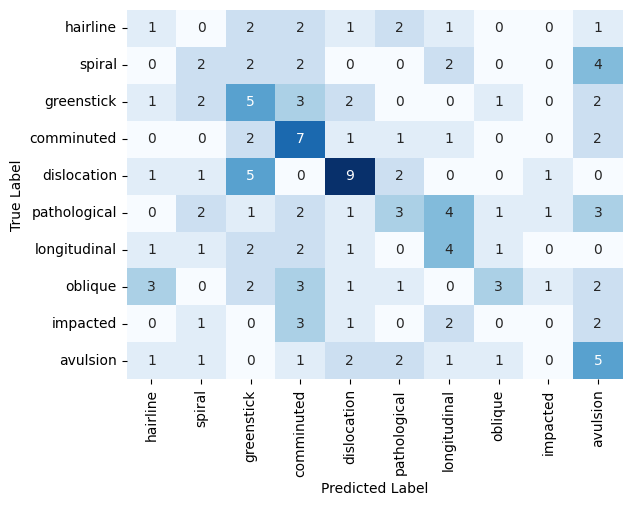

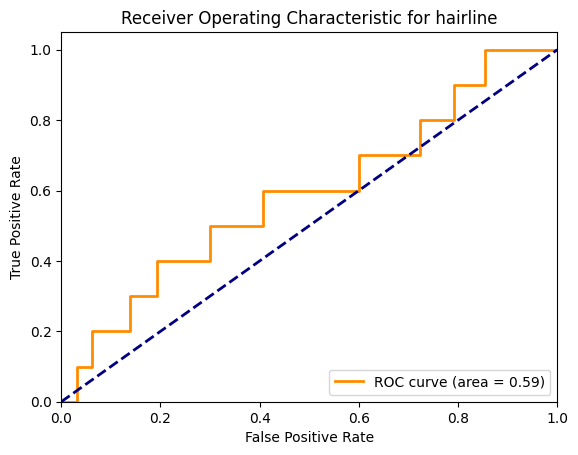

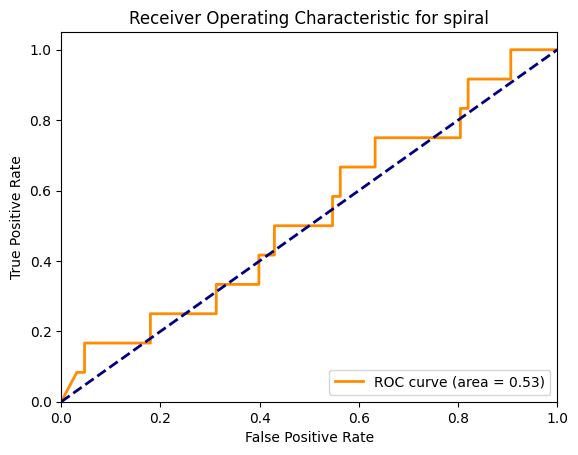

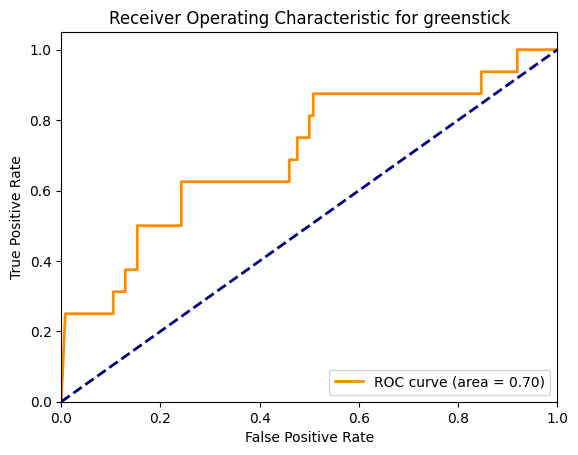

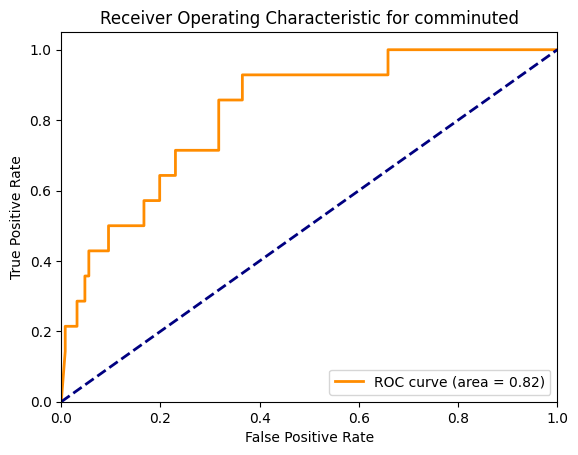

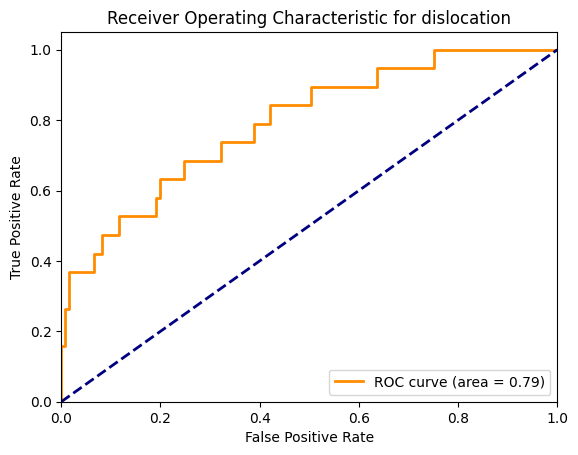

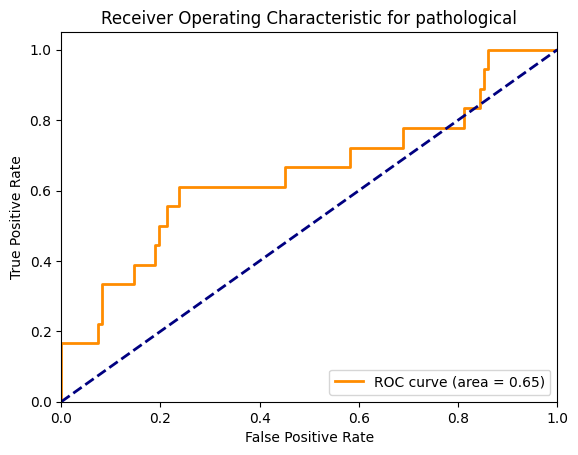

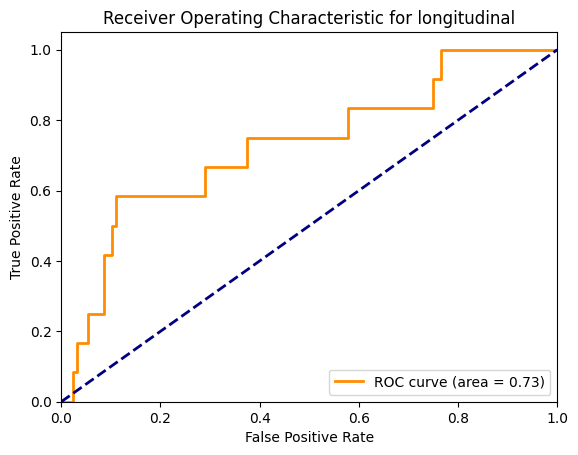

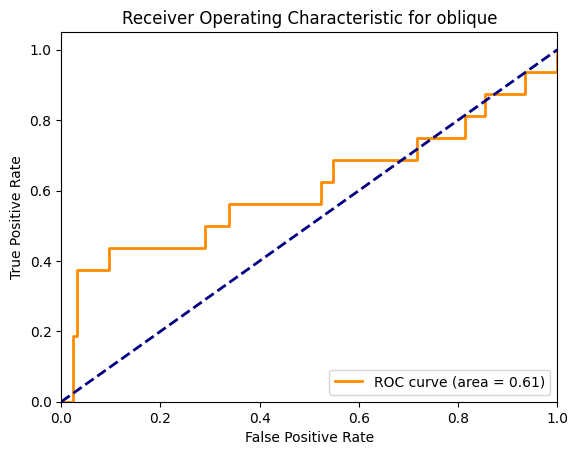

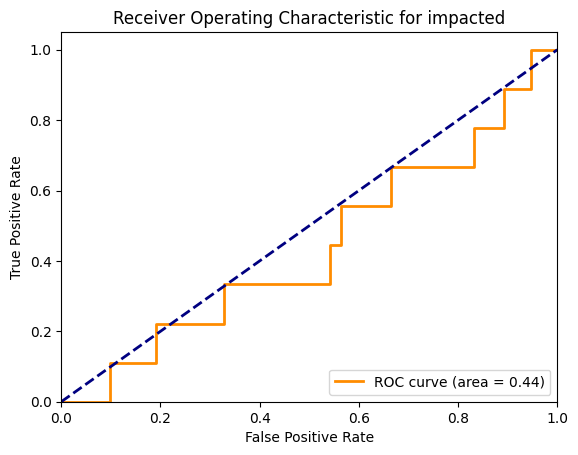

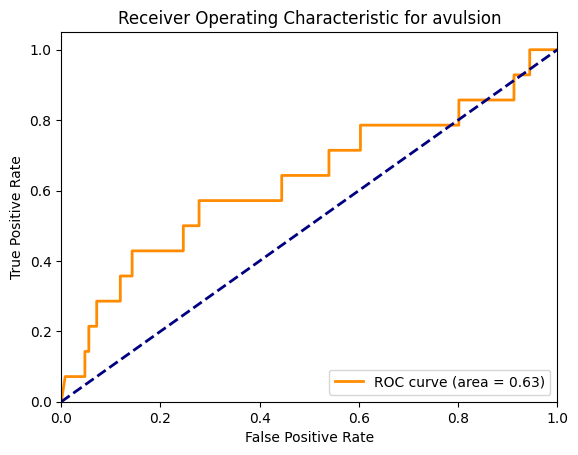

Accuracy: 0.2785714285714286
Classification Report:


,precision,recall,f1-score,support
hairline,0.125000,0.100000,0.111111,10.000000
spiral,0.200000,0.166667,0.181818,12.000000
greenstick,0.238095,0.312500,0.270270,16.000000
comminuted,0.280000,0.500000,0.358974,14.000000
dislocation,0.473684,0.473684,0.473684,19.000000
pathological,0.272727,0.166667,0.206897,18.000000
longitudinal,0.266667,0.333333,0.296296,12.000000
oblique,0.428571,0.187500,0.260870,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.238095,0.357143,0.285714,14.000000


In [12]:
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(images_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report


## Model 2: HOG Feature Only

In [13]:
#images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
#images_model.fit(hog_train, y_train)
start_time = time.time()
rand_search.fit(hog_train, y_train)
training_time = time.time() - start_time
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
print(f"Training time: {training_time:.2f} seconds")

Best parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 1}
Best score: 0.2143348377390931
Training time: 347.24 seconds


Inference time: 0.10 seconds


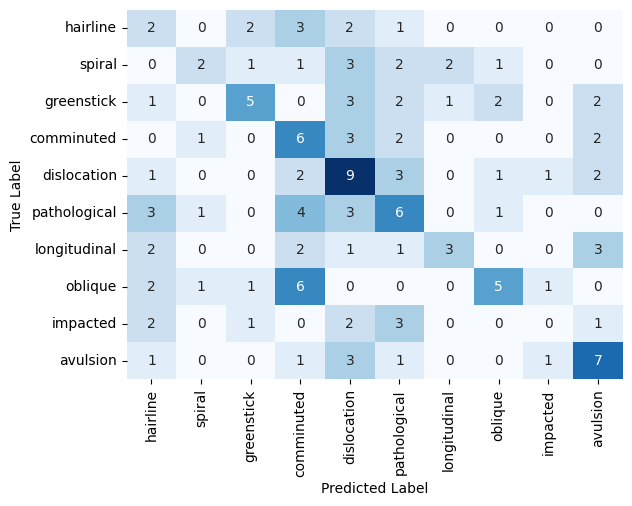

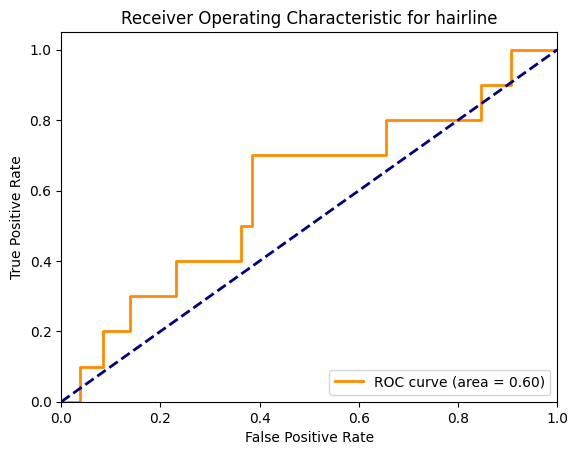

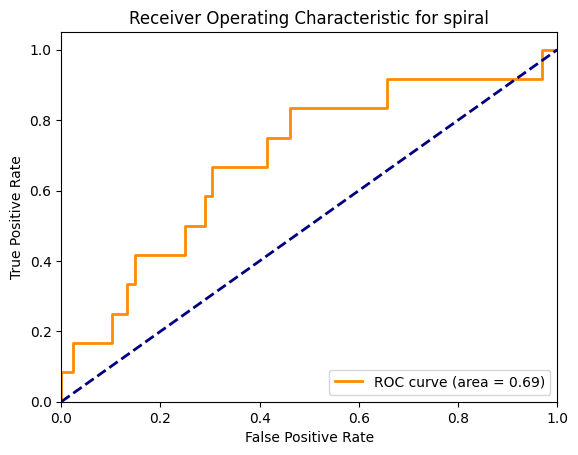

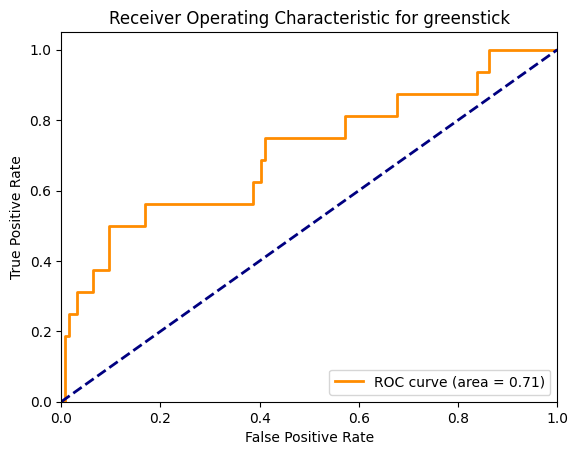

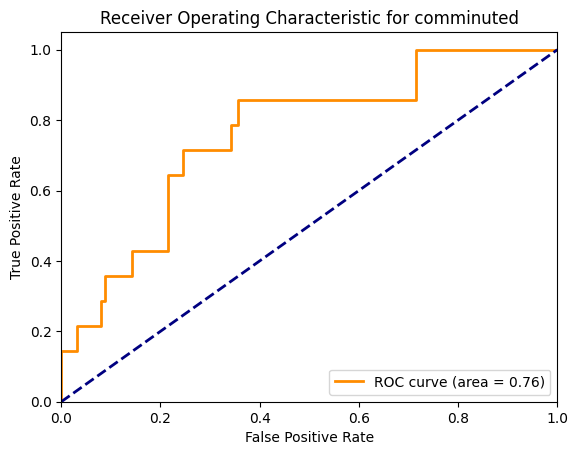

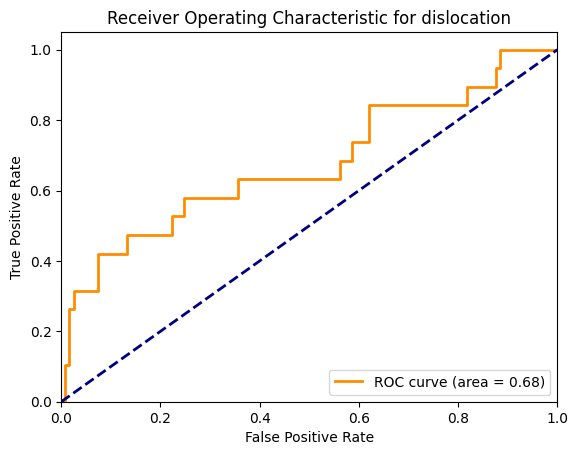

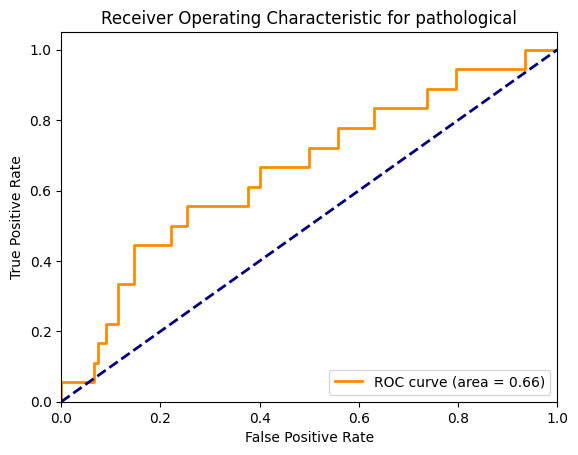

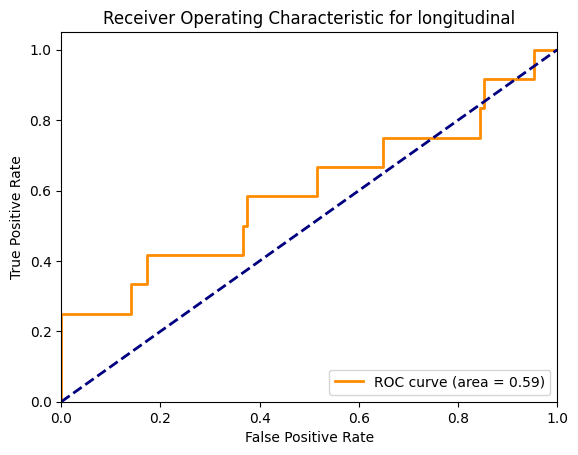

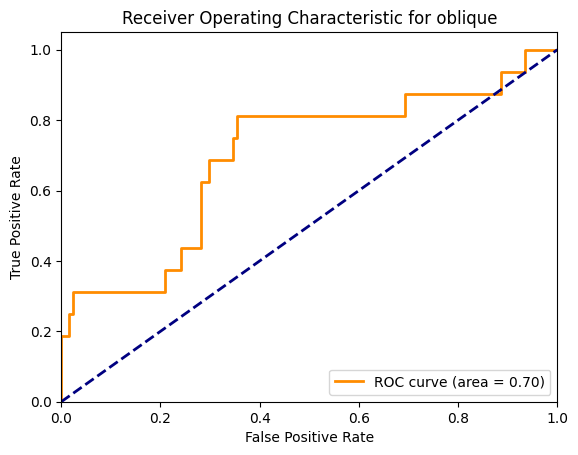

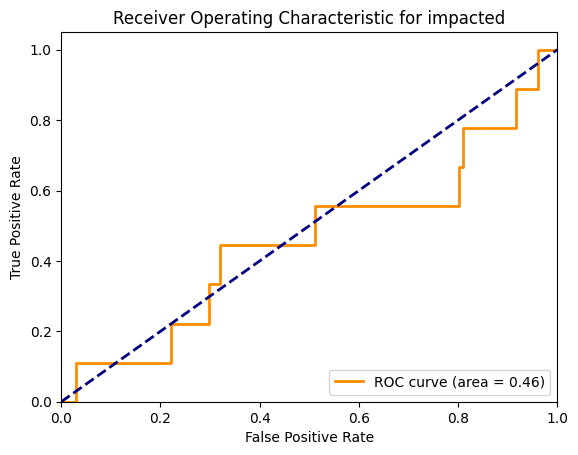

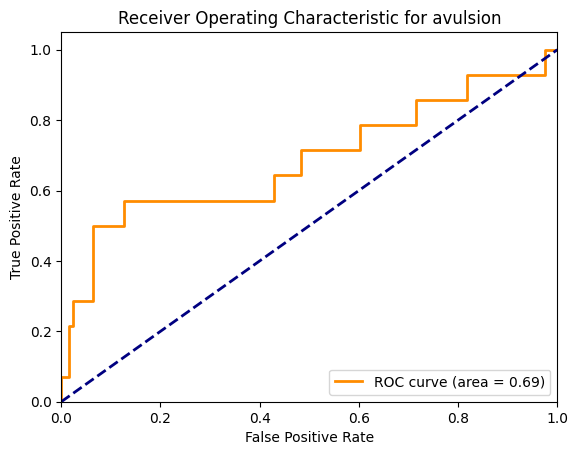

Accuracy: 0.32142857142857145
Classification Report:


,precision,recall,f1-score,support
hairline,0.142857,0.200000,0.166667,10.000000
spiral,0.400000,0.166667,0.235294,12.000000
greenstick,0.500000,0.312500,0.384615,16.000000
comminuted,0.240000,0.428571,0.307692,14.000000
dislocation,0.310345,0.473684,0.375000,19.000000
pathological,0.285714,0.333333,0.307692,18.000000
longitudinal,0.500000,0.250000,0.333333,12.000000
oblique,0.500000,0.312500,0.384615,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.411765,0.500000,0.451613,14.000000


In [14]:
#y_pred = images_model.predict(hog_test)
images_model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = images_model.predict(hog_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [15]:
#images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
#images_model.fit(canny_edges_train, y_train)
start_time = time.time()
rand_search.fit(canny_edges_train, y_train)
training_time = time.time() - start_time
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
print(f"Training time: {training_time:.2f} seconds")

Best parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 1}
Best score: 0.1546651929630653
Training time: 301.23 seconds


Inference time: 0.08 seconds


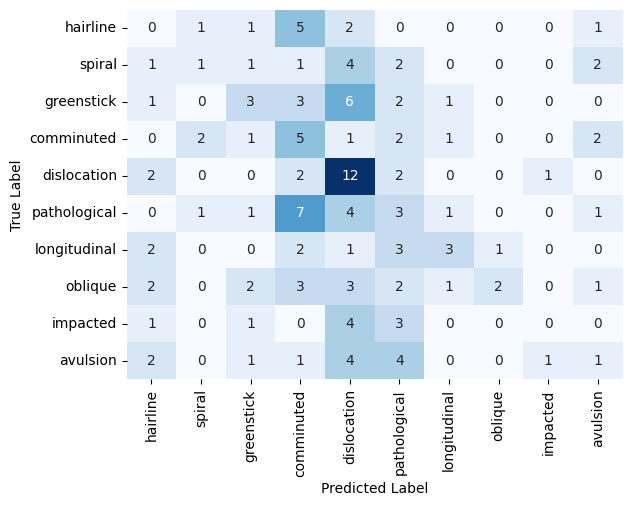

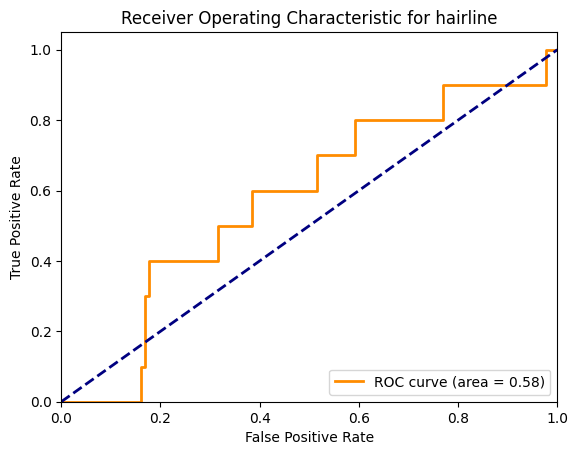

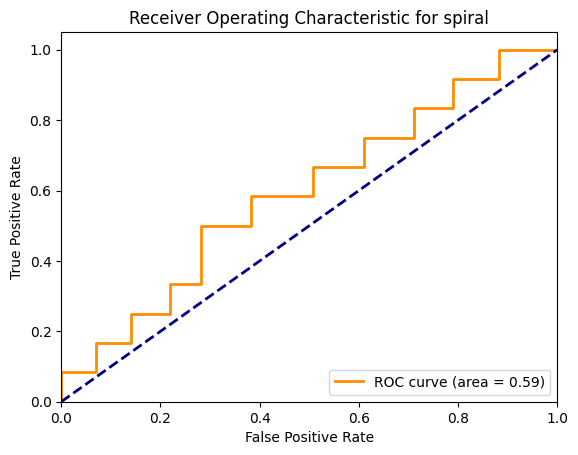

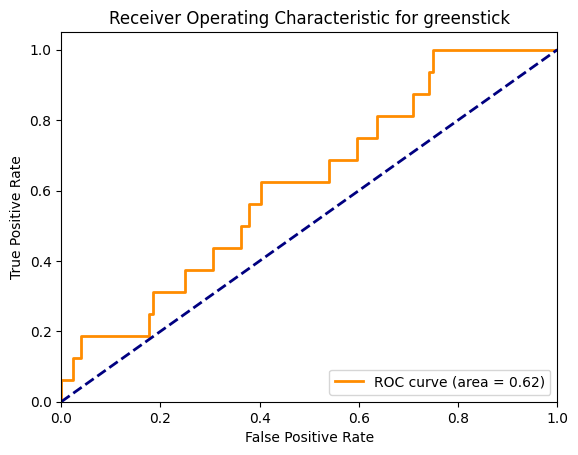

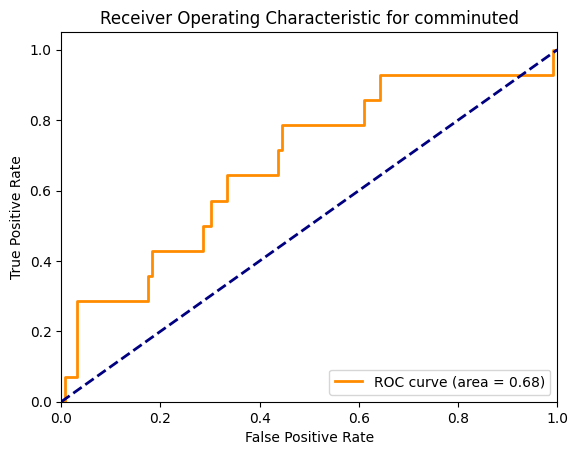

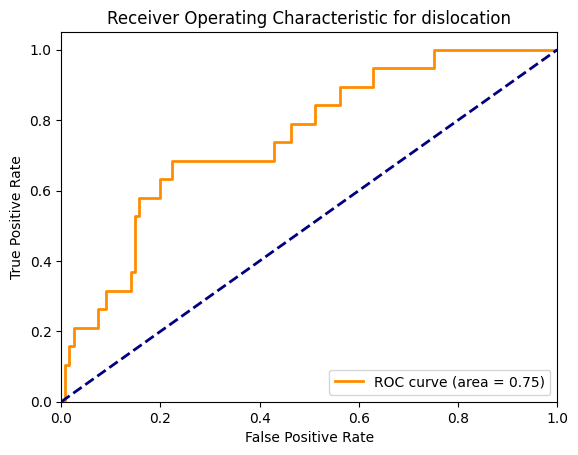

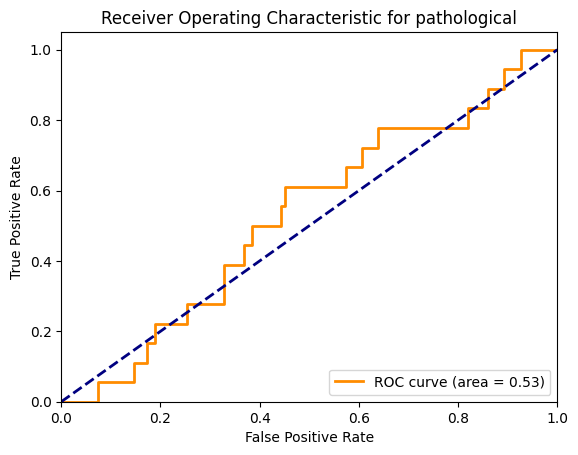

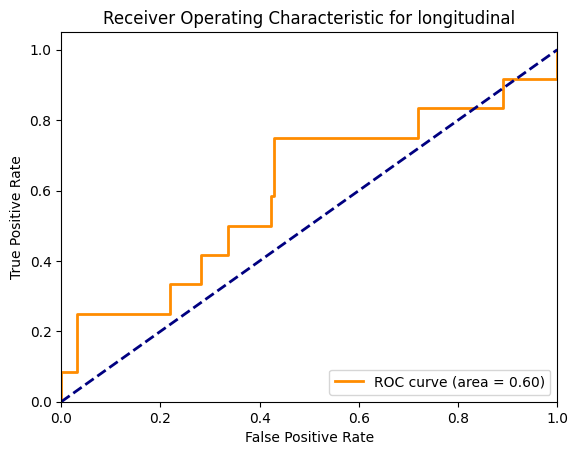

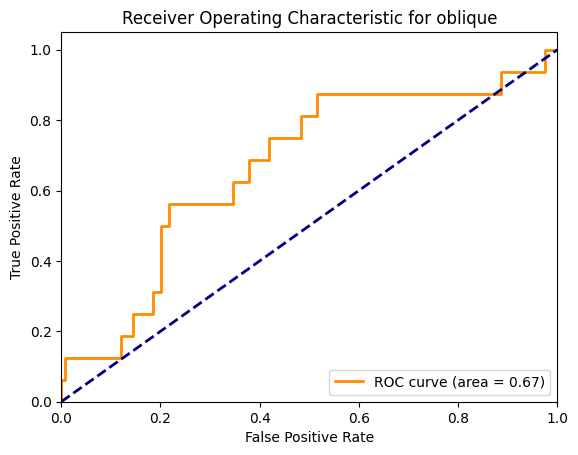

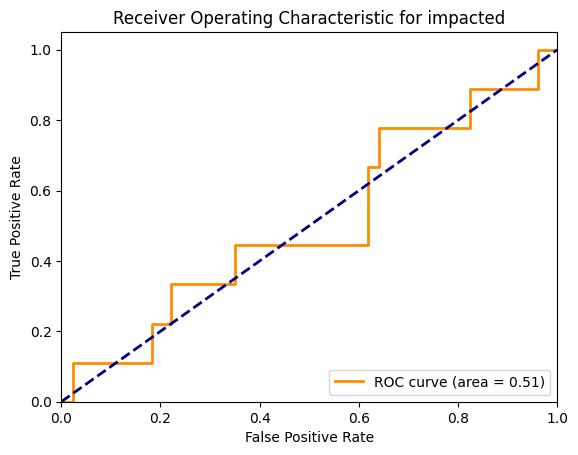

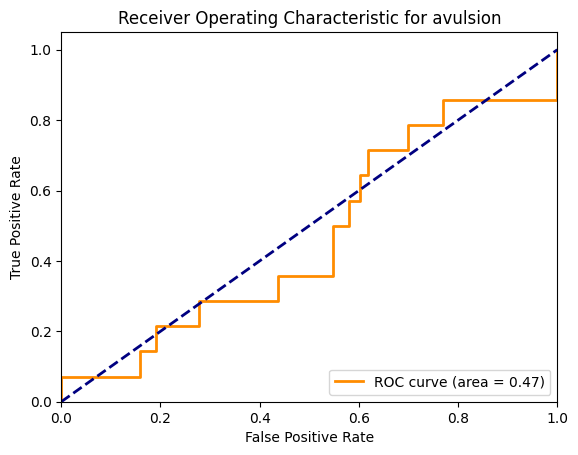

Accuracy: 0.21428571428571427
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.200000,0.083333,0.117647,12.000000
greenstick,0.272727,0.187500,0.222222,16.000000
comminuted,0.172414,0.357143,0.232558,14.000000
dislocation,0.292683,0.631579,0.400000,19.000000
pathological,0.130435,0.166667,0.146341,18.000000
longitudinal,0.428571,0.250000,0.315789,12.000000
oblique,0.666667,0.125000,0.210526,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.125000,0.071429,0.090909,14.000000


In [16]:
#y_pred = images_model.predict(canny_edges_test)
images_model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = images_model.predict(canny_edges_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [17]:
#images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
#mages_model.fit(contours_train, y_train)
start_time = time.time()
rand_search.fit(contours_train, y_train)
training_time = time.time() - start_time
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
print(f"Training time: {training_time:.2f} seconds")

Best parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.01}
Best score: 0.18297872340425533
Training time: 312.40 seconds


Inference time: 0.07 seconds


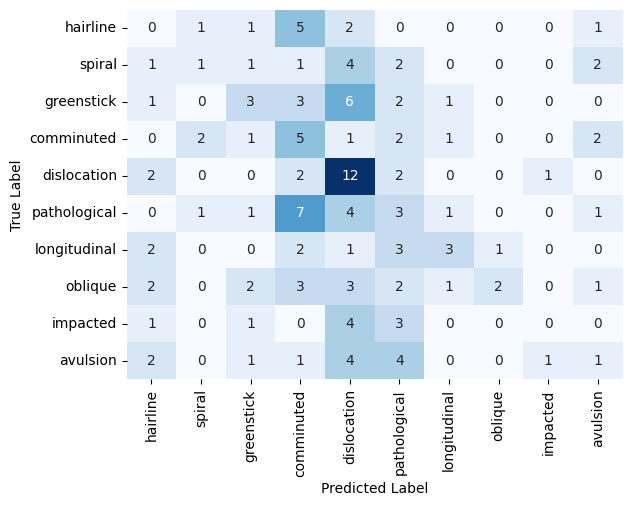

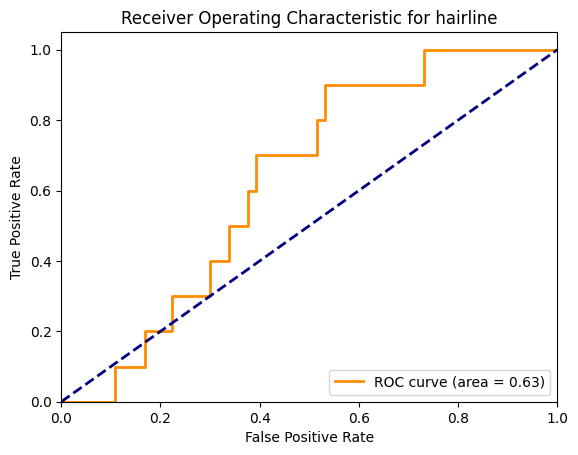

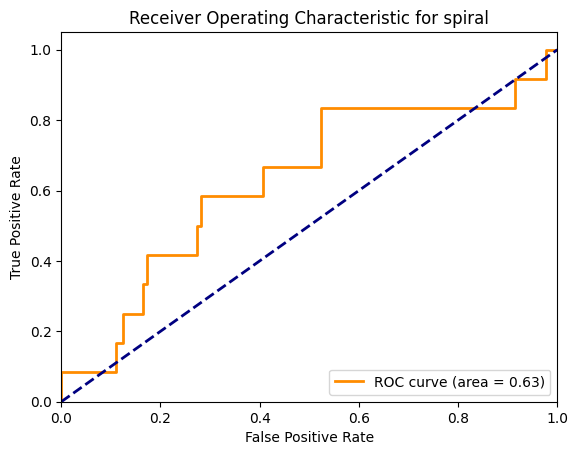

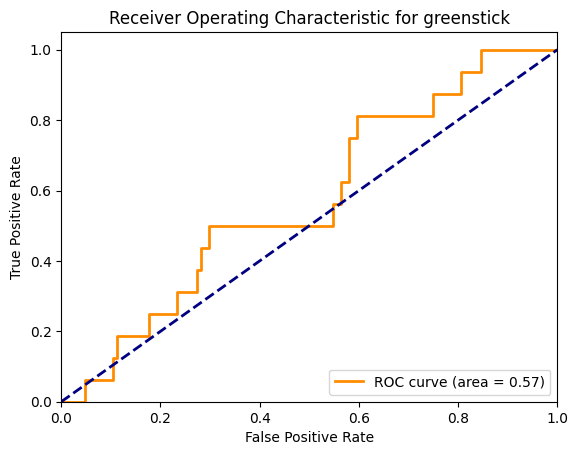

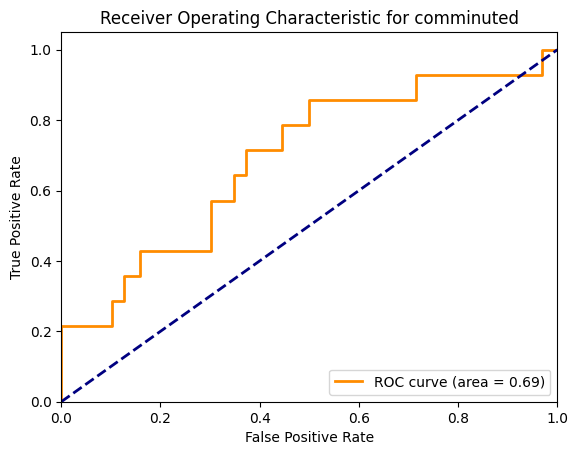

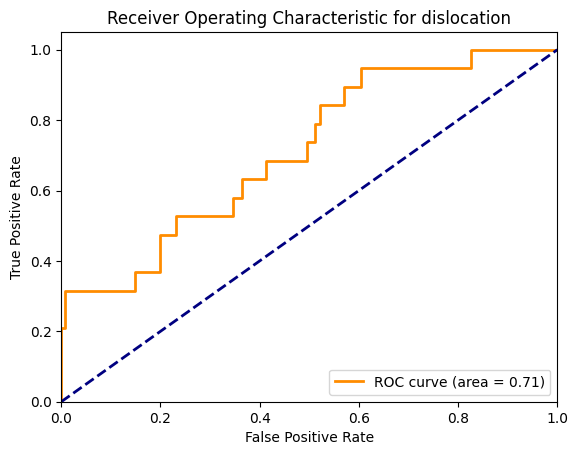

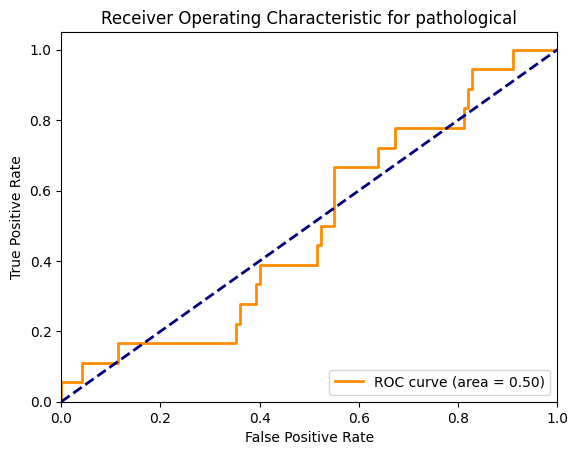

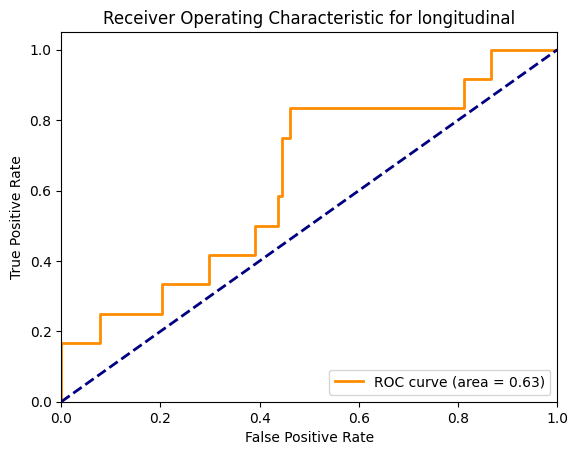

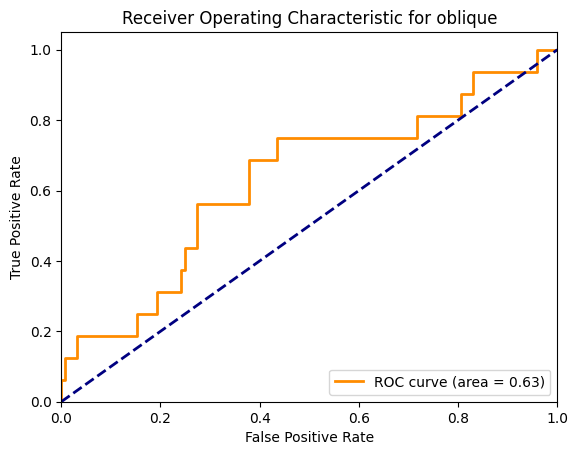

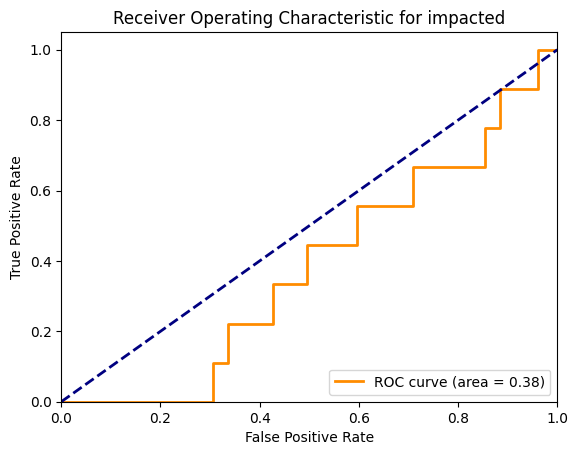

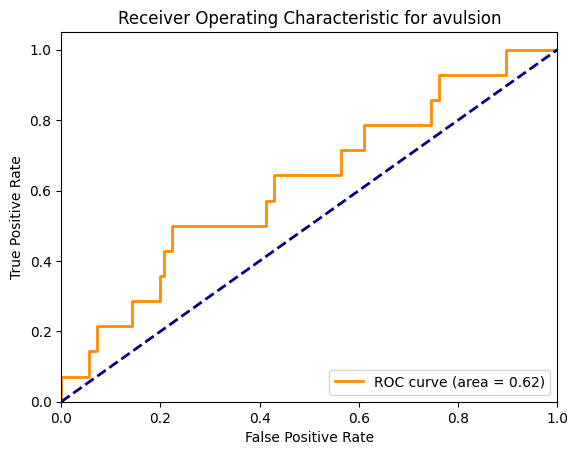

Accuracy: 0.19285714285714287
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.200000,0.083333,0.117647,12.000000
greenstick,0.272727,0.187500,0.222222,16.000000
comminuted,0.172414,0.357143,0.232558,14.000000
dislocation,0.292683,0.631579,0.400000,19.000000
pathological,0.130435,0.166667,0.146341,18.000000
longitudinal,0.428571,0.250000,0.315789,12.000000
oblique,0.666667,0.125000,0.210526,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.125000,0.071429,0.090909,14.000000


In [18]:
#y_pred_images = images_model.predict(contours_test)
images_model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred_images = images_model.predict(contours_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred_images)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: Best Combination

In [19]:
X_train = np.hstack((images_train, hog_train))
X_test = np.hstack((images_test, hog_test))


In [23]:
#images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
#images_model.fit(X_train, y_train)
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
print(f"Training time: {training_time:.2f} seconds")

Best parameters: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 1}
Best score: 0.20925363053022628
Training time: 3601.86 seconds


Inference time: 0.54 seconds


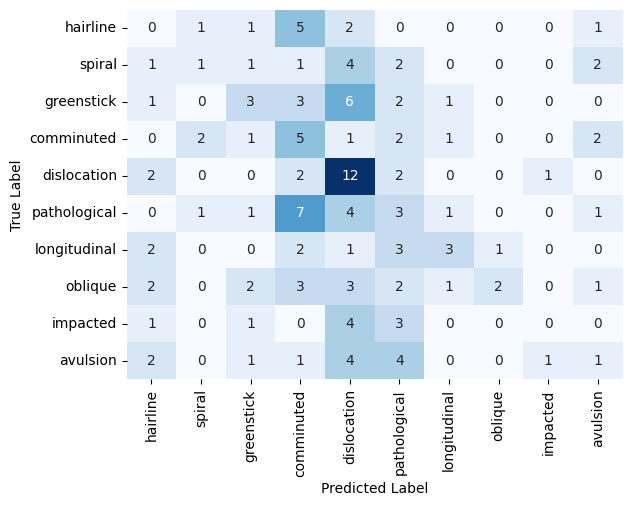

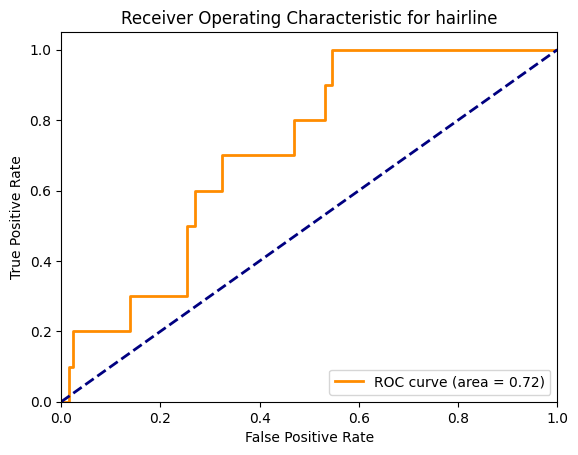

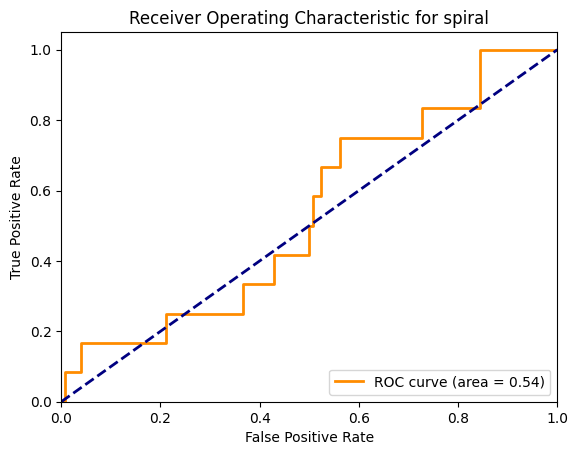

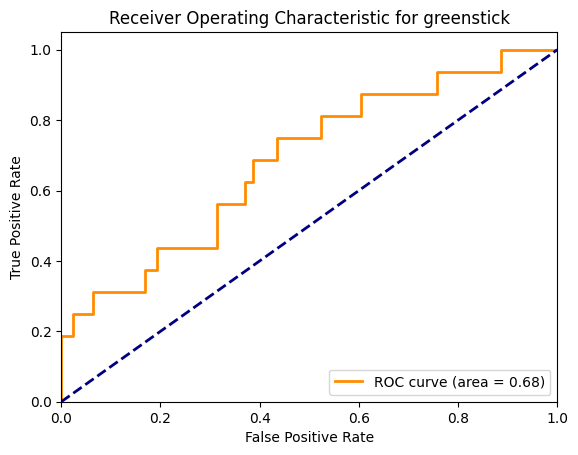

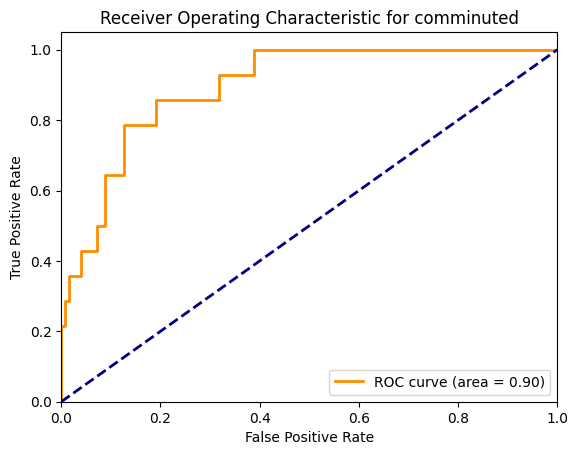

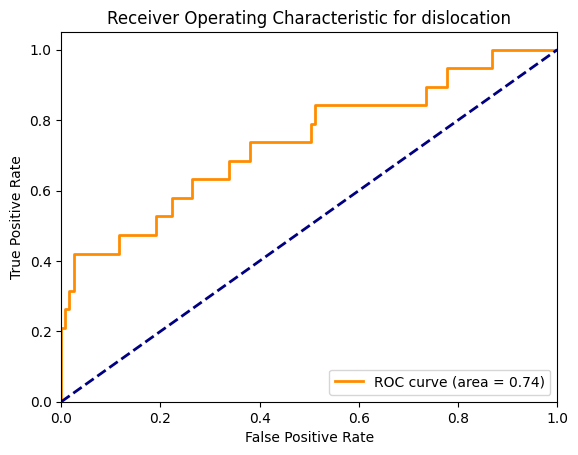

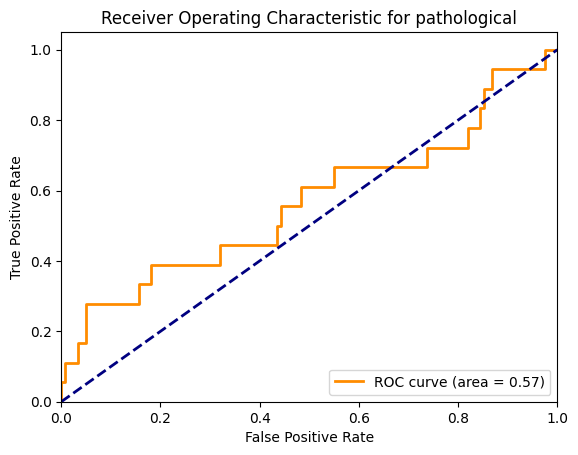

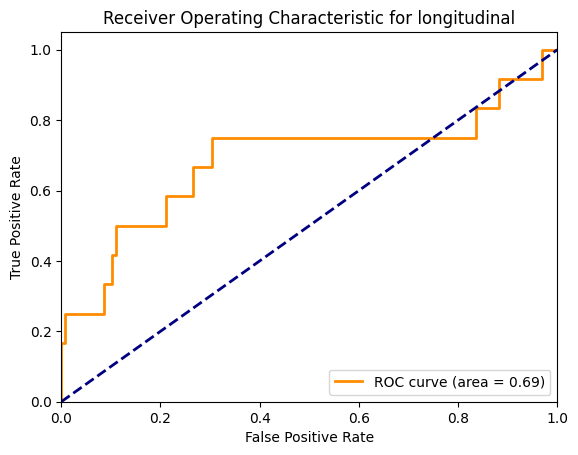

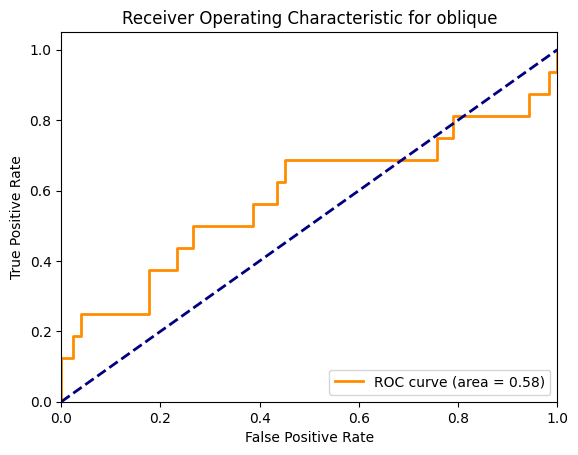

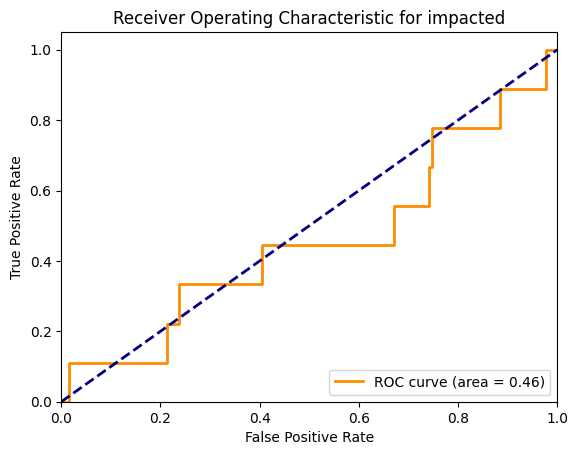

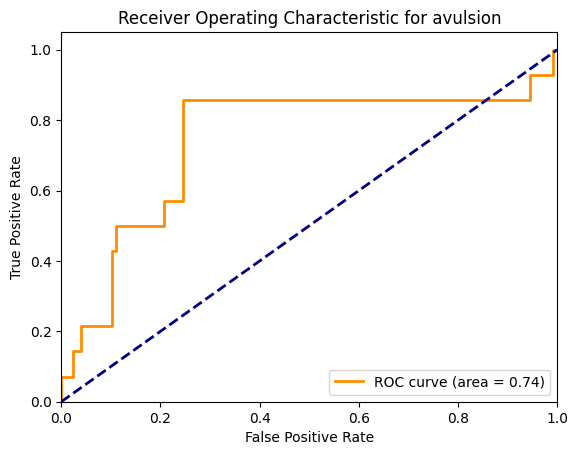

Accuracy: 0.30714285714285716
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.200000,0.083333,0.117647,12.000000
greenstick,0.272727,0.187500,0.222222,16.000000
comminuted,0.172414,0.357143,0.232558,14.000000
dislocation,0.292683,0.631579,0.400000,19.000000
pathological,0.130435,0.166667,0.146341,18.000000
longitudinal,0.428571,0.250000,0.315789,12.000000
oblique,0.666667,0.125000,0.210526,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.125000,0.071429,0.090909,14.000000


In [24]:
#y_pred_images = images_model.predict(X_test)
images_model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred_images = images_model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

accuracy = accuracy_score(y_test, y_pred_images)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report